In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (410, 615, 3)


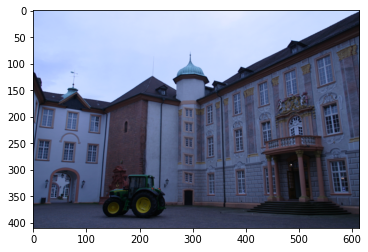

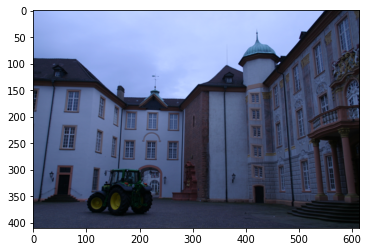

In [4]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('../data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

[ WARN:0@0.793] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


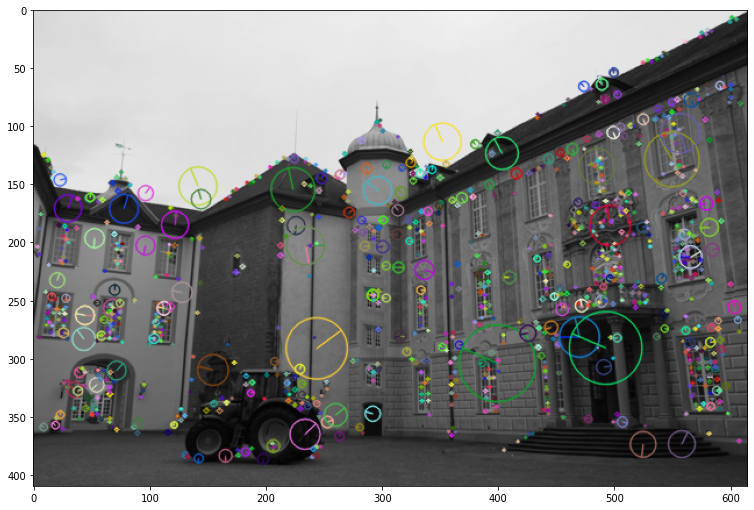

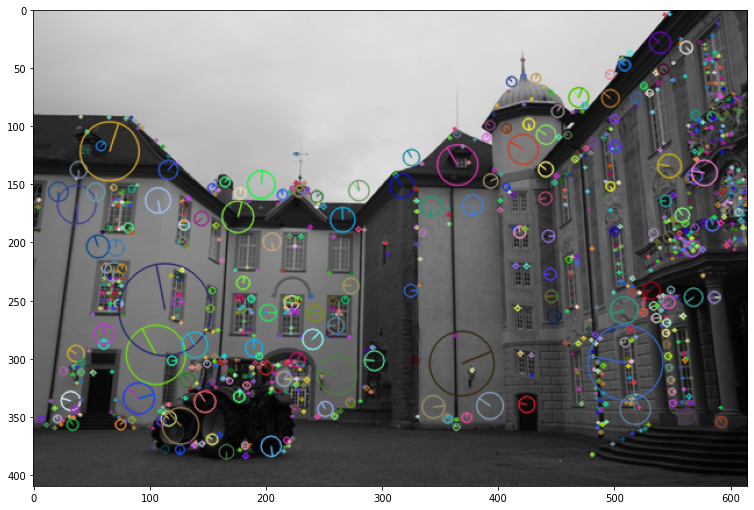

In [5]:
""" Detects SIFT features in all of the images
"""
import cv2
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


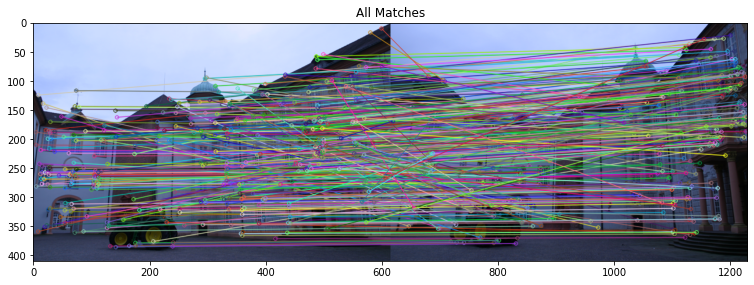

In [6]:
""" Matches the detected keypoints between the images
"""
import cv2
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [7]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [8]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.03483464  0.19532636  0.00230723]
 [ 0.12138734  0.96929545 -0.08251168]
 [-0.48165932 -0.00994682 -0.8760465 ]]


In [9]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

[113 281  68 155 329 356 229 334 217]
[241 367 298 359 263 261 212  43 255]
[ 10 185 279 386  17 231 227  98  56  24  31 153  70 230]
[271  76 103 308 150 157 229  92 110  20 122 174]
[ 66 341 295 243 129 338 328  56 106 316 286 315 208 324 349 294 298 319
 133 290 287 291 169 302 170  97 164  88 109 292 242 304 345 331 332  99
 343 199 348 207 305 330 327 306 326]
[381  34  29 184 216 126 162  31 269  72  32 233 218]
[160 210 151 247 191  74 186 307 119  27]
[284  71 326 389 148  12 196 315 233 180]
[215 303 365 334 291  41 168  96 235  83 261 141]
[327.  79.  39. 239. 344. 164. 197. 123.]
[124 140 295 252 327 136 370 132 305 306 358 180]
[313 250 108  17 174 301 206  84  24 154  16  15 135 303 251]
[118 240 265  19 163 333 287 294 386 268]
[136 265 366 307 332   6   2 385  67 372  84 188]
[321. 142. 299. 137. 366.  26. 198.  79.]
[139  53 111 291  90 115 120 272 194 212 240 146 147 373]
[363 238 266 183 323 343 368  96 314 118]
[ 72  61  45 160  32 271 100 152  71  69  21  68 127]
[ 

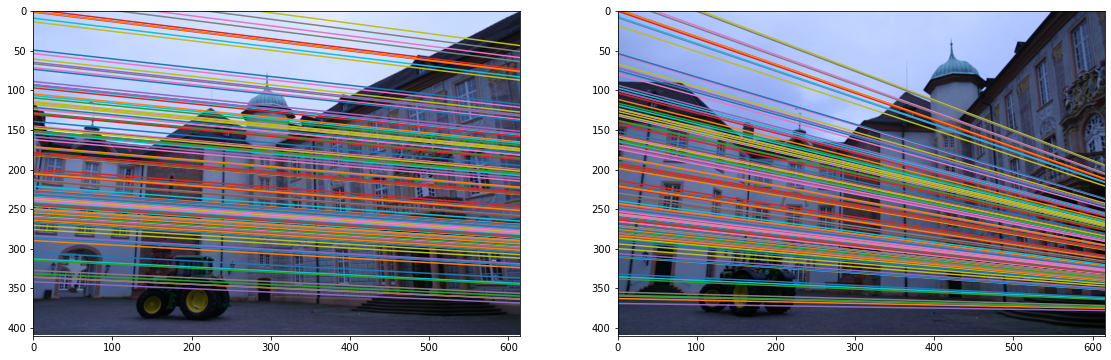

In [ ]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [ ]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([0.98745161, 0.08009256, 0.13610471]), 'R': array([[-0.71215634, -0.25302671, -0.65483649],
       [-0.23165076,  0.96523977, -0.12103767],
       [-0.66269999, -0.06549563,  0.74601545]])}, {'T': array([0.98745161, 0.08009256, 0.13610471]), 'R': array([[ 0.71215634,  0.25302671,  0.65483649],
       [ 0.23165076, -0.96523977,  0.12103767],
       [ 0.66269999,  0.06549563, -0.74601545]])}, {'T': array([-0.98745161, -0.08009256, -0.13610471]), 'R': array([[-0.71215634, -0.25302671, -0.65483649],
       [-0.23165076,  0.96523977, -0.12103767],
       [-0.66269999, -0.06549563,  0.74601545]])}, {'T': array([-0.98745161, -0.08009256, -0.13610471]), 'R': array([[ 0.71215634,  0.25302671,  0.65483649],
       [ 0.23165076, -0.96523977,  0.12103767],
       [ 0.66269999,  0.06549563, -0.74601545]])}]
-0.9999999999999993
0.9999999999999993
-0.9999999999999993
0.9999999999999993


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [ ]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

best 376 (393,)
not best 0
not best 17
not best 0
[[  1.37598628  -5.27181967 -42.92337268   1.35536418   0.83011984
    4.59092417  27.6682613   27.6682613   53.79734109  -2.07291386
   19.4430395   -5.97861716  26.82213177  -1.14665416  17.20552195
    1.19041594  17.71150471   1.69672329   1.39117152  22.17753085
   -3.49357456  -5.85374982  19.89744538  14.0318555   -6.03895465
    1.47320025  12.87150403  -6.63130614  13.66242304   6.83249635
   10.69031336   1.40943602   1.25429948   6.20582975  40.88066579
   -6.43215923  11.86039618  14.91764753   7.75180488   7.75180488
    4.85693812  -0.65795454   8.48092555   1.22489549   1.12778362
  -15.82419746   5.77619648   6.62379194   1.04419857   5.55006022
    6.24139219   5.37619496   7.92532439   8.18324545   0.74796596
  -13.7619077    4.55504795   7.54331042   3.69629324   4.98928318
    4.98928318   4.98928318   5.04422833   5.04422833   6.62038569
    5.02089017   5.02089017   5.9337058  -10.18321597 -10.18321597
    4.947059

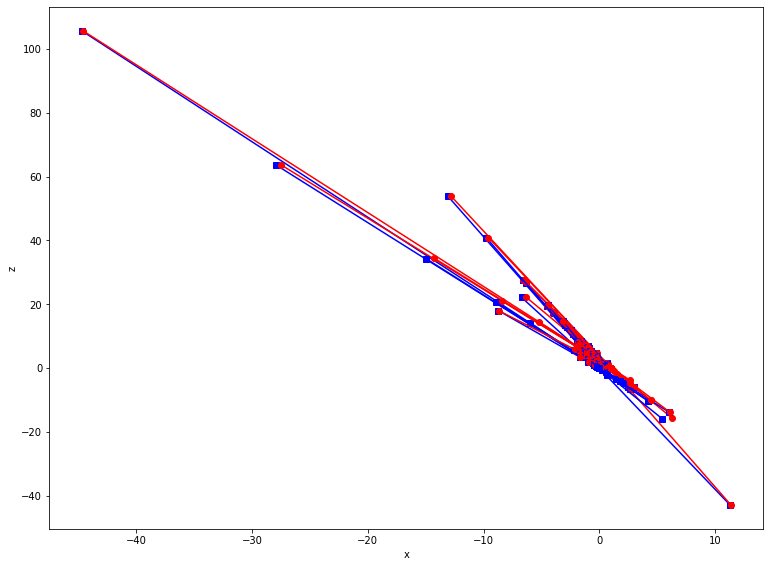

In [ ]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

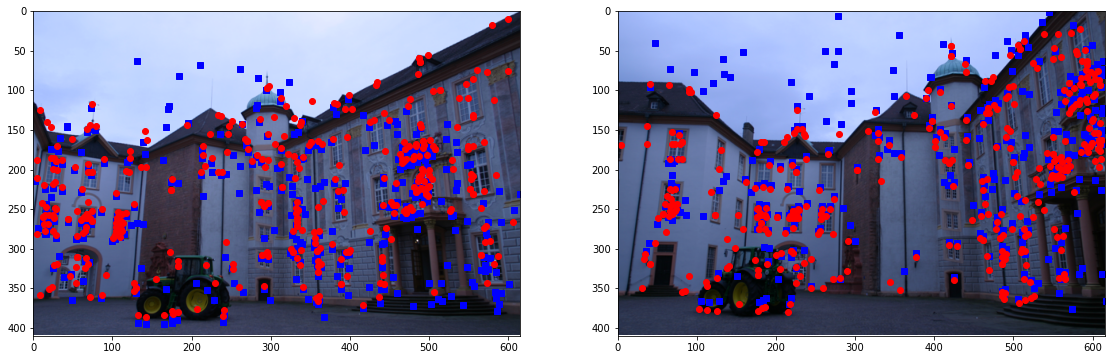

In [ ]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)